# Module 5 Examples - Data Preparation

Building on the last assignment, we will now prepare the AirBnB data set for downstream analysis. In particular, we want to eventually use this data to get an understanding of how profitable AirBnBs really are in Chicago. Keep in mind that there are a lot of tips and tricks out there for how to most effectively use pandas, and you will discover them over time.  These examples, at times, go beyond the "base" level code, but only for the purpose of giving you ideas of what is out there.  Remember, if there is an action you want to do, there is probably a way to do it in pandas!

In [63]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
listings = pd.read_csv('Chicago_airbnb_listings.csv')

In [64]:
listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20240323200240,2024-03-23,city scrape,Hyde Park - Walk to UChicago,You are invited stay in the guest room of my v...,The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, IL",My apartment is a 2nd floor walk-up in a centu...,within an hour,100%,91%,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone']",t,t,"Chicago, Illinois, United States",Hyde Park,NaN,41.787900,-87.587800,Private room in condo,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Free washer \u2013 In building"", ""Coffee"", ""...",$86.00,3,89,2,3,1125,1125,3.0,1125.0,NaN,t,13,36,62,309,2024-03-23,234,23,2,2015-01-09,2024-03-12,4.99,4.98,4.99,4.99,4.98,4.96,4.94,R17000015609,f,1,0,1,0,2.09
1,7126,https://www.airbnb.com/rooms/7126,20240323200240,2024-03-24,city scrape,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,https://www.airbnb.com/users/show/17928,Sarah,2009-05-19,"Chicago, IL",We live in Chicago. We love to travel and see ...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/17928/profile...,https://a0.muscache.com/im/users/17928/profile...,Ukrainian Village,1,2,"['email', 'phone']",t,t,"Chicago, Illinois, United States",West Town,NaN,41.901660,-87.680210,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Smart lock"", ""Books and reading material"", ""...",$90.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,20,43,61,294,2024-03-24,516,31,1,2009-07-03,2024-03-03,4.70,4.85,4.56,4.90,4.87,4.89,4.75,R24000114046,f,1,1,0,0,2.88
2,10945,https://www.airbnb.com/rooms/10945,20240323200240,2024-03-24,city scrape,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,https://www.airbnb.com/users/show/33004,At Home Inn,2009-08-21,"Chicago, IL","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,97%,93%,t,https://a0.muscache.com/im/pictures/user/e23d4...,https://a0.muscache.com/im/pictures/user/e23d4...,Old Town,9,86,"['email', 'phone', 'work_email']",t,t,NaN,Lincoln Park,NaN,41.911960,-87.639810,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Free washer \u2013 In building"", ""Lake acces...",$114.00,4,120,2,4,1125,1125,3.9,1125.0,NaN,t,6,19,26,162,2024-03-24,83,23,1,2014-04-28,2024-03-06,4.65,4.80,4.80,4.80,4.84,4.98,4.66,2209984,t,6,6,0,0,0.69
3,12140,https://www.airbnb.com/ro

## Deleting Columns

To make the columns more manageable, we will first eliminate the columns that we know we will not need later.  In the EDA, we should have found that there were two columns with no non-null values.  There's no use keeping these, so we will go ahead and delete them.

In [65]:
listings = listings.drop(['neighbourhood_group_cleansed','calendar_updated'],axis=1) #this deletes the listed columns. An axis of 1 means columns, whereas 0 means rows
listings.shape

(7707, 73)

We can also delete other columns that are not likely going to be of use to us.  One example of this are the URL columns; they are either easily recreatable with other columns, like property ID, or they are for image data that we will not be able to use for our analysis. Let's find and eliminate these columns.

While we could delete these one at a time, wouldn't it be nice if we could find and delete all of the columns with 'url' in their title at once? To help, we notice a pattern that all of these columns have the text 'url' in the title, but we could also look for text like "https://". In the next module we will look at a more sophisticated way to code this, but for now we will take this one step at a time using methods we have already learned.

In [66]:
col_names = listings.columns.to_list() #this gets a list of all of the columns in the dataframe
col_names_to_delete = ([col for col in col_names if "url" in col]) #this uses list comprehension to find only those column names that include the substring "url"
col_names_to_delete
listings = listings.drop(col_names_to_delete,axis=1) #the drop command can take a list of columns as well as a single column name like we used before
listings.shape

['listing_url',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

(7707, 68)

We could also choose to remove a number of other columns that probably aren't going to help us.  For example, after verifying that all of the listings have last scraped dates within a day of each other, we can remove this just to make our data look a little more manageable.  Below you will see a few other columns have been dropped. We'll probably want to remove more of these later, so this is just a first pass.

In [67]:
listings = listings.drop(['scrape_id','last_scraped','source'],axis=1)

## Filtering

As this is an Airbnb dataset, let's say we aren't interested in any listings for hotels so let's filter out any listings for hotels. We can do this by using pandas string manipulations to identify any rows that contain the text 'hotel'.

In [68]:
# The simple way to do this is to filter out exact values, like below:
listings[listings['property_type'] != 'Room in hotel']
#However, this can be annoying to individually find and delete for each value (as there are several different values that represent hotels). Instead, let's use string manipulation.
listings = listings[listings['property_type'].str.contains('hotel')==False] #finds all rows where the property_type column includes the text 'hotel' and filters these out of the dataframe
listings.shape

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,Hyde Park - Walk to UChicago,You are invited stay in the guest room of my v...,The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, IL",My apartment is a 2nd floor walk-up in a centu...,within an hour,100%,91%,t,Hyde Park,1,1,"['email', 'phone']",t,t,"Chicago, Illinois, United States",Hyde Park,41.787900,-87.587800,Private room in condo,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Free washer \u2013 In building"", ""Coffee"", ""...",$86.00,3,89,2,3,1125,1125,3.0,1125.0,t,13,36,62,309,2024-03-23,234,23,2,2015-01-09,2024-03-12,4.99,4.98,4.99,4.99,4.98,4.96,4.94,R17000015609,f,1,0,1,0,2.09
1,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, IL",We live in Chicago. We love to travel and see ...,within an hour,100%,100%,t,Ukrainian Village,1,2,"['email', 'phone']",t,t,"Chicago, Illinois, United States",West Town,41.901660,-87.680210,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Smart lock"", ""Books and reading material"", ""...",$90.00,2,60,2,2,1125,1125,2.0,1125.0,t,20,43,61,294,2024-03-24,516,31,1,2009-07-03,2024-03-03,4.70,4.85,4.56,4.90,4.87,4.89,4.75,R24000114046,f,1,1,0,0,2.88
2,10945,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, IL","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,97%,93%,t,Old Town,9,86,"['email', 'phone', 'work_email']",t,t,NaN,Lincoln Park,41.911960,-87.639810,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Free washer \u2013 In building"", ""Lake acces...",$114.00,4,120,2,4,1125,1125,3.9,1125.0,t,6,19,26,162,2024-03-24,83,23,1,2014-04-28,2024-03-06,4.65,4.80,4.80,4.80,4.84,4.98,4.66,2209984,t,6,6,0,0,0.69
3,12140,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,46734,Shay And Robert,2009-10-18,"Chicago, IL",Best in the city with long-time urban-dwelling...,within a day,100%,100%,f,Lincoln Park,1,1,"['email', 'phone']",t,t,"Chicago, Illinois, United States",Lincoln Park,41.923570,-87.649470,Room in boutique hotel,Private room,3,1.0,1 private bath,1.0,1.0,"[""Fire extinguisher"", ""Iron"", ""Heating"", ""Sham...",$329.00,2,10,1,2,10,10,2.0,10.0,t,29,54,78,165,2024-03-24,15,2,0,2015-06-29,2023-05-21,4.93,4.67,5.00,5.00,5.00,5.00,4.87,R20000055258,f,1,0,1,0,0.14
4,24833,Prime LincolnPark 1 Block Fullerton Express L ...,Perfect private entrance apartment one block f...,Lincoln Park is a great neighborhood where peo...,101521,Red,2010-03-31,"Chicago, IL",Travel is fun and exciting but can be hard on ...,within a few hours,100%,85%,t,Lincoln Park,9,13,"['email', 'phone']",t,t,"Chicago, Illinois, United Stat

(7553, 65)

## Cleaning

### Duplicates

In [69]:
listings[listings.duplicated()] #finds any duplicated rows. remember, by default this is interpreted as listings rows where the duplicated property is true, and is equivalent to the statement listings[listings.duplicated()==True]

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


Luckily, our data has no duplicates, but this is definitely something you always want to check!

### Missing Data
Note, isnull() and isna() can be used interchangeably and do the same thing

In [70]:
listings.isnull() #this isn't a very helpful view -- let's see if how many rows have any null values
listings[listings.isna().any(axis=1)].shape #by using the .any keyword, we are checking to see if any of the values in the row are null.  .all is another keyword you can use. 

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True
7703,False,False,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

(4970, 65)

We can see that the majority of our data has at least one null value, so we probably don't want to fully delete every row with a null.  We have a few strategies we could take here, but since our EDA suggested that all of the datapoints had non-null values for vital identifiers like id and name, we'll move forward with a thresholding approach. Let's first try to get a sense of the percent of missing data in each row.

0     2583
1     1190
2     1035
3      653
4      387
11     380
14     263
12     254
13     205
10     171
15      96
5       92
16      67
6       60
17      48
18      32
7       20
8        7
19       6
9        3
20       1
Name: count, dtype: int64

<Axes: >

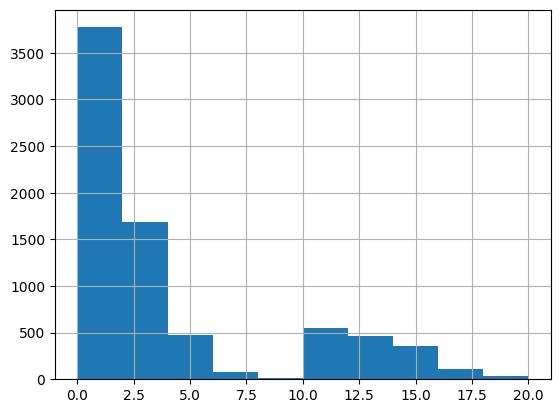

In [71]:
counts = listings.isnull().sum(axis=1) #here, we are using the same isnull() method, but instead of just returning a boolean value like with .any or .all, we are passing that forward into a summing function that returns a count for every row
counts.value_counts(ascending=False)
counts.hist() #we can then visualize this to get a sense for the data

While highly context dependent, a general rule of thumb is that it can become harder to work with data once it's missing 20-25% of the data points, provided this represents a very small portion of the overall dataset. It doesn't look like there are too many data points that would be affected by this rule (~1%), leaving us with a workable dataset, so it seems reasonable to remove these data as a first pass.  We can always come back and remove more later if need be.

Keep in mind that this approach should not be applied blindly! If you are only interested in certain columns, using a threshold doesn't make sense; you'd want to filter based on if those columns are null instead. How to filter depends on the type of questions you are interested in answering.

In [72]:
threshold_count = .75*len(listings.columns)
listings = listings.dropna(axis=0, thresh=threshold_count)
listings.shape

(7466, 65)

### Outliers
In the EDA, we could see that there were some extreme values, that could skew our analysis if included as is.  An example of this would be stays with a very high number of minimum nights (e.g. a couple months or more). At this point, we might conclude that these listings are no longer for short-term stays, but are for people looking for tenants. Let's go ahead and remove these listings.

In [73]:
len(listings[listings['minimum_nights']>=45]) #check to make sure it is reasonable to get rid of this amount of data
listings = listings[listings['minimum_nights']<=45]
listings.shape
listings['minimum_nights'].describe()

110

(7359, 65)

count    7359.000000
mean       12.464601
std        14.299711
min         1.000000
25%         2.000000
50%         2.000000
75%        32.000000
max        45.000000
Name: minimum_nights, dtype: float64

### Changing Values
Finally, let's look at how we can replace values.

In [74]:
listings['neighbourhood'].value_counts() 

neighbourhood
Chicago, Illinois, United States           5281
Oak Park, Illinois, United States             4
Chicago , Illinois, United States             3
Chicago, United States                        2
Calumet Park, Illinois, United States         1
Rogers Park, Il, United States                1
Evergreen Park, Illinois, United States       1
Riverdale, Illinois, United States            1
Elmwood Park, Illinois, United States         1
Name: count, dtype: int64

Looking at the value counts above, we can see that all of these are in Chicago or surrounding areas, but there are a few different representations of 'Chicago' that we'd ideally like to merge.

Let's combine all of the 'Chicago' values first.

In [75]:
listings['neighbourhood'] = listings['neighbourhood'].replace({'Chicago , Illinois, United States': 'Chicago, Illinois, United States', 'Chicago, United States': 'Chicago, Illinois, United States'}) #replaces the other values of Chicago so they are all in the same format
listings['neighbourhood'] = listings['neighbourhood'].replace({'Rogers Park, Il, United States': 'Rogers Park, Illinois, United States'}) #replaces a single value
listings['neighbourhood'].value_counts() 

neighbourhood
Chicago, Illinois, United States           5286
Oak Park, Illinois, United States             4
Calumet Park, Illinois, United States         1
Rogers Park, Illinois, United States          1
Evergreen Park, Illinois, United States       1
Riverdale, Illinois, United States            1
Elmwood Park, Illinois, United States         1
Name: count, dtype: int64

## Transforming/Augmenting Data
Transforming and augmenting are very related topics as they are performing very similar actions, but for different reasons.

First, let's augment the data by adding a new column based on summing the values from other columns.  While we can see the total number of listings a host has and can break this down by the type, it would also be nice to see at a glance how many rooms a host has listed in the area, so we will add a column for this.

In [76]:
listings['host_rooms_in_area'] = listings['calculated_host_listings_count_private_rooms']+ listings['calculated_host_listings_count_shared_rooms'] #this is simply creating a new column that is the sum of values in other columns
listings

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_rooms_in_area
0,2384,Hyde Park - Walk to UChicago,You are invited stay in the guest room of my v...,The apartment is less than one block from beau...,2613,Rebecca,2008-08-29,"Chicago, IL",My apartment is a 2nd floor walk-up in a centu...,within an hour,100%,91%,t,Hyde Park,1,1,"['email', 'phone']",t,t,"Chicago, Illinois, United States",Hyde Park,41.787900,-87.587800,Private room in condo,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Free washer \u2013 In building"", ""Coffee"", ""...",$86.00,3,89,2,3,1125,1125,3.0,1125.0,t,13,36,62,309,2024-03-23,234,23,2,2015-01-09,2024-03-12,4.99,4.98,4.99,4.99,4.98,4.96,4.94,R17000015609,f,1,0,1,0,2.09,1
1,7126,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",17928,Sarah,2009-05-19,"Chicago, IL",We live in Chicago. We love to travel and see ...,within an hour,100%,100%,t,Ukrainian Village,1,2,"['email', 'phone']",t,t,"Chicago, Illinois, United States",West Town,41.901660,-87.680210,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Smart lock"", ""Books and reading material"", ""...",$90.00,2,60,2,2,1125,1125,2.0,1125.0,t,20,43,61,294,2024-03-24,516,31,1,2009-07-03,2024-03-03,4.70,4.85,4.56,4.90,4.87,4.89,4.75,R24000114046,f,1,1,0,0,2.88,0
2,10945,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,33004,At Home Inn,2009-08-21,"Chicago, IL","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,97%,93%,t,Old Town,9,86,"['email', 'phone', 'work_email']",t,t,NaN,Lincoln Park,41.911960,-87.639810,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Free washer \u2013 In building"", ""Lake acces...",$114.00,4,120,2,4,1125,1125,3.9,1125.0,t,6,19,26,162,2024-03-24,83,23,1,2014-04-28,2024-03-06,4.65,4.80,4.80,4.80,4.84,4.98,4.66,2209984,t,6,6,0,0,0.69,0
4,24833,Prime LincolnPark 1 Block Fullerton Express L ...,Perfect private entrance apartment one block f...,Lincoln Park is a great neighborhood where peo...,101521,Red,2010-03-31,"Chicago, IL",Travel is fun and exciting but can be hard on ...,within a few hours,100%,85%,t,Lincoln Park,9,13,"['email', 'phone']",t,t,"Chicago, Illinois, United States",Lincoln Park,41.925961,-87.656364,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,1.0,"[""Drying rack for clothing"", ""Free washer \u20...",$57.00,32,395,32,32,395,395,32.0,395.0,t,0,18,18,239,2024-03-24,40,1,0,2010-05-24,2023-04-22,4.29,4.07,4.00,4.13,4.03,4.90,4.20,City registration pending,f,4,4,0,0,0.24,0
5,25879,2/1 One Block to Fullerton L Red Line Deck & ...,"Terrific 2 bed, 1 bath unit in an older brick ...","Safe, tree-lined neighborhood with easy beach ...",101521,Red,2010-03-31,"Chicago, IL",Travel is fun and exciting but can be hard on ...,within a few hours,100%,85%,t,Lincoln Park,9,13,

We also note that we have both a column for the number of host listings in the area (`calculated_host_listings_count`) as well as the number of total host listings (`host_total_listings_count`). Since we have the local count already, let's transform the total count colums so we can easily see how many listings each host has outside of the Chicago area. To do this, we will use applying.  This example is very similar to the previous one, but can make it easier to perform more complex calculations.  There is also a more sophisticated way we can do this that we will learn about in the next module.

host_total_listings_count
0       2454
1       1154
2        714
4691     554
3        421
        ... 
35         1
73         1
65         1
253        1
49         1
Name: count, Length: 69, dtype: int64

<Axes: >

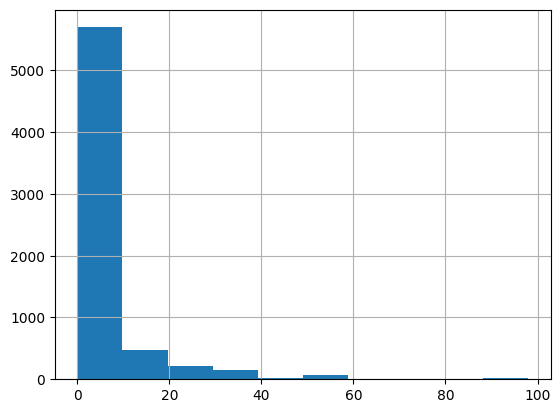

In [77]:
def difference(row): #This function simply shows how to calculate the difference between two columns
	return row['host_total_listings_count']-row['calculated_host_listings_count']

listings['host_total_listings_count'] = listings.apply(difference,axis=1) #using the function to populate a new column
listings['host_total_listings_count'].value_counts(ascending=False)
listings['host_total_listings_count'][listings['host_total_listings_count']<100].hist()

From this, we can see that there is a pretty wide spread between hosts tha have very few properties and one that have a lot. But wait! Since we saw that a lot of hosts have multiple listings in the Chicago area, looking at the value counts will include duplicated hosts.  Let's de-duplicate the hosts and look at this again.

host_total_listings_count
0       1617
1        680
2        328
3        160
4         95
        ... 
253        1
2908       1
76         1
98         1
49         1
Name: count, Length: 69, dtype: int64

<Axes: >

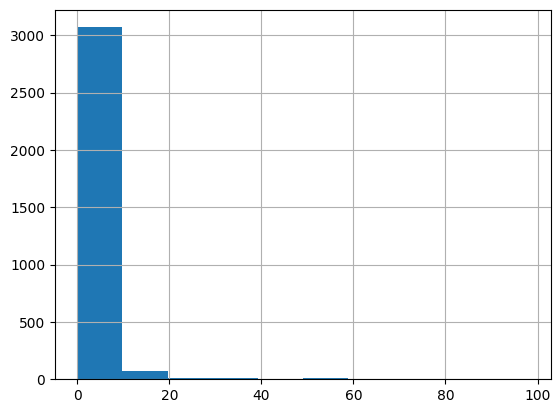

In [78]:
unique_hosts = listings.drop_duplicates(subset=['host_id'],keep='first')
unique_hosts['host_total_listings_count'].value_counts(ascending=False)
unique_hosts['host_total_listings_count'][unique_hosts['host_total_listings_count']<100].hist()

While the distribution isn't too different, the values are!

This goes to show how EDAs and data cleaning are very iterative processes.  After making these initial preparations, the next step would be to perform another EDA and then perfrorming further cleaning and preparation as necessary.